# Une autre réforme en augmentant légèrement la part du PIB

On commence par initialiser le simulateur et importer des bibliothèques utiles.

In [1]:
from retraites.SimulateurRetraites import SimulateurRetraites
import pylab as pl
from scipy import interpolate
from copy import deepcopy

In [2]:
simulateur = SimulateurRetraites('../retraites/fileProjection.json')
analyse = simulateur.pilotageCOR()

## Détermination de la trajectoire des dépenses

On commence par récupérer les données passées

In [3]:
analyse = simulateur.pilotageCOR()
s=2
analyse.scenarios=[s] # on se concentre sur le scenario 1,3% croissance

annees_constatees = []
depenses_constatees = []
for a in simulateur.annees:
    if (a<2021):
        annees_constatees.append(a)
        depenses_constatees.append(analyse.Depenses[s][a])

Puis on prévoit d'augmenter légèrement la part PIB, de 0.8% tous les 10 ans

In [4]:
annees = [2020, 2030, 2040, 2050, 2060, 2070]
depenses = [0.136 + 0.008*i for i in range(len(annees))]
nb_annees = len(annees)

Pour compléter les données entre deux dates imposées, nous utilisons l'interpolateur du module scipy, fondé sur une spline quadratique.

In [5]:
depenses_interpolateur = interpolate.interp1d(annees, depenses, kind="quadratic")

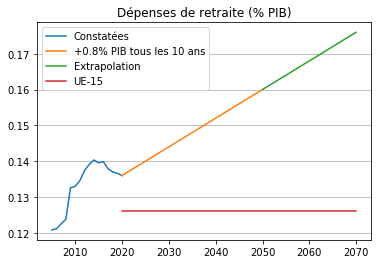

In [6]:
annees_table_EI = range(2020,2051)
depenses_table_EI = depenses_interpolateur(annees_table_EI)

annees_table_extrapolation = range(2050,2071)
depenses_table_extrapolation = depenses_interpolateur(annees_table_extrapolation)

pl.plot(annees_constatees, depenses_constatees, label="Constatées")
pl.plot(annees_table_EI, depenses_table_EI, label="+0.8% PIB tous les 10 ans")
pl.plot(annees_table_extrapolation, depenses_table_extrapolation, label="Extrapolation")
#pl.ylim(bottom=0.11, top=0.145)
pl.title("Dépenses de retraite (% PIB)");
pl.plot(annees,[0.126]*nb_annees, label="UE-15")
pl.legend();
pl.grid(axis="y")

On recolle les morceaux et cela nous donne la trajectoire de dépenses en pourcentage du PIB :

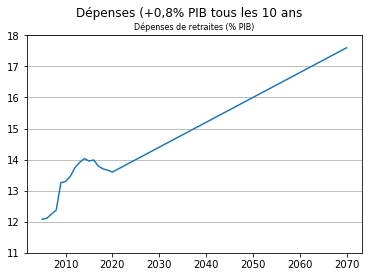

In [7]:
depenses_EI = analyse.Depenses
for a in simulateur.annees_futures:
    if (a>=2020):
        depenses_EI[s][a] = depenses_interpolateur(a)
            
pl.suptitle("Dépenses (+0,8% PIB tous les 10 ans");
analyse.graphique("Depenses", depenses_EI)
pl.grid(axis="y")
pl.ylim(bottom=11.0, top=18);

## Calcul du taux de cotisation

On suppose que le système est équilibré à partir de 2020, de sorte à en déduire l'évolution du taux de cotisation


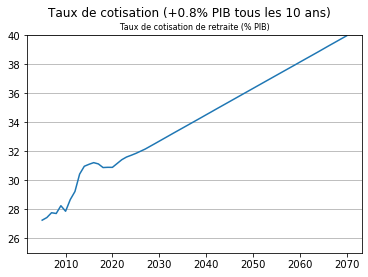

In [8]:
taux_EI = analyse.T
for a in simulateur.annees_futures:
    taux_EI[s][a] = depenses_EI[s][a]/simulateur.B[s][a]
    
pl.suptitle("Taux de cotisation (+0.8% PIB tous les 10 ans)")
analyse.graphique("T", taux_EI)
pl.grid(axis="y")
#pl.ylim(bottom=27.0, top=32)

## Calcul de l'évolution de l'âge pour maintenir le niveau de pension

On calcule l'âge pour maintenir le niveau de pension et avoir un équilibre

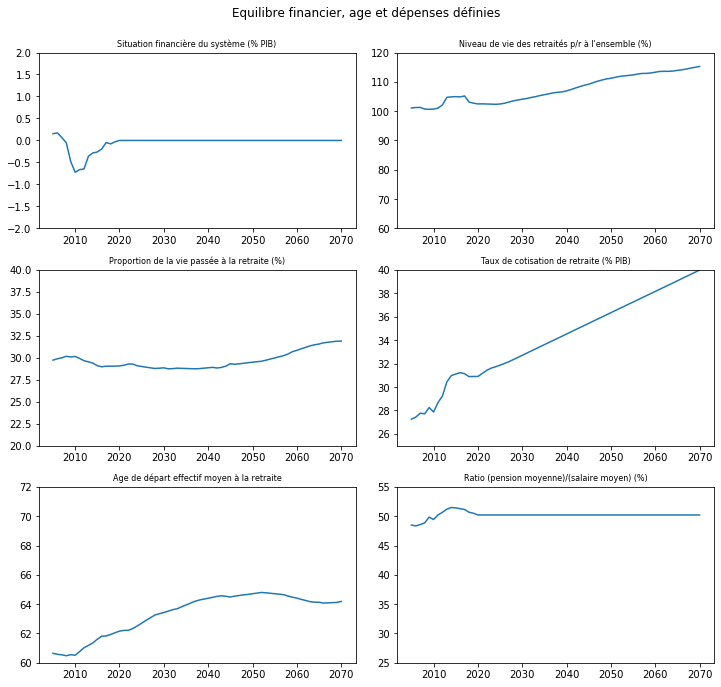

In [9]:
analyse_COR = simulateur.pilotageCOR()
Pension_COR_2020 = analyse_COR.P[1][2020]
analyse = simulateur.pilotageParCotisationsEtPensions(Pcible=Pension_COR_2020, Scible=0.0)
analyse.scenarios=[s]

pl.figure(figsize=(10,10))
pl.suptitle(u"Equilibre financier, age et dépenses définies")
analyse.dessineSimulation()

Acible=deepcopy(analyse.A)

En faisant une interpolation entre un départ à 62 ans et l'âge calculé plus haut, on balaye les possibilités de réalisations (toujours sous la contrainte système équilibré et taux de cotisation) et on trace l'évolution des courbes ages-pension en fonction des années.

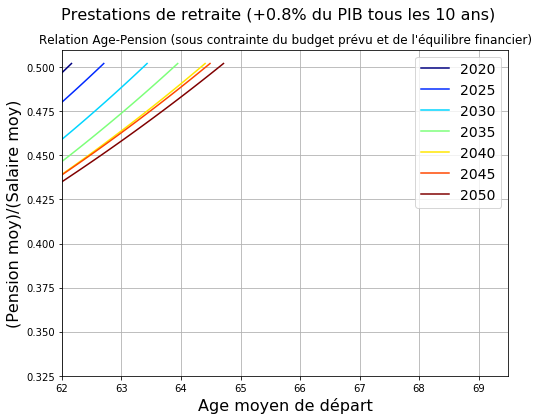

In [10]:
annees = range( 2020,2051,5 )
lx = [ [] for i in range(len(annees)) ]
ly = [ [] for i in range(len(annees)) ]

for x in pl.arange(0.0,1.001,0.01):

    for a in simulateur.annees_futures:
        analyse.A[s][a] = 62*(1-x) + Acible[s][a]*x
    
    analyse = simulateur.pilotageParCotisationsEtAge(Acible = analyse.A, Tcible = taux_EI, Scible=0.0)
    
    for i in range(len(annees)):
        lx[i].append( analyse.A[s][annees[i]] )
        ly[i].append( analyse.P[s][annees[i]] )

# pour avoir une jolie grille
fig = pl.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
major_ticks = pl.arange(62, 73, 1)
ax.set_xticks(major_ticks)
pl.grid()

colors = pl.cm.jet(pl.linspace(0,1,len(annees)))

pl.suptitle("Prestations de retraite (+0.8% du PIB tous les 10 ans)",fontsize=16)
pl.title("Relation Age-Pension (sous contrainte du budget prévu et de l'équilibre financier)")
pl.xlabel("Age moyen de départ",fontsize=16)
pl.ylabel("(Pension moy)/(Salaire moy)",fontsize=16)
pl.xlim(62,69.5)
pl.ylim(0.325,0.51)

# trace les courbes
for i in range(len(annees)):
    pl.plot(lx[i],ly[i], label=str(annees[i]), color=colors[i])

pl.legend(fontsize=14)

#pl.savefig("evolution2.png")

En haut à gauche du graphique, c'est la pension rêvée du point de point de vue individuel: départ tôt et pension élevée. En bas à droite, c'est la pensée cauchemar.
En 2020, on a une pension rêvée. 